In [1]:
import os
import cv2
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
def set_seed(seed=123):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
# 1. 生成數據(將png 與txt 都放在trainging_data 的資料夾)

def generate_data(num_samples=100, output_dir='training_data'):
    os.makedirs(output_dir, exist_ok=True)

    # 清除舊檔案（保留資料夾）
    for f in os.listdir(output_dir):
        path = os.path.join(output_dir, f)
        if os.path.isfile(path):
            os.remove(path)

    # 圖案模板
    circle_pattern = np.array([
        [0, 1, 1, 1, 0],
        [1, 0, 0, 0, 1],
        [1, 0, 0, 0, 1],
        [1, 0, 0, 0, 1],
        [0, 1, 1, 1, 0]
    ])

    cross_pattern = np.array([
        [1, 0, 0, 0, 1],
        [0, 1, 0, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1]
    ])

    for sample_idx in range(num_samples):
        if random.random() > 0.5:
            pattern, label = circle_pattern, 0
        else:
            pattern, label = cross_pattern, 1

        # === 隨機縮放比例 ===
        # scale = random.uniform(0.8, 1.2)
        scale = random.choice([
            random.uniform(0.7, 0.9),  # 30% 小目標
            random.uniform(0.9, 1.1),  # 40% 中等目標
            random.uniform(1.1, 1.3)   # 30% 大目標
        ])
        pattern_resized = cv2.resize(pattern.astype(np.uint8) * 255, dsize=None,         # cv2.resize 放大或縮小圖形，模擬不同大小
                                     fx=scale, fy=scale, interpolation=cv2.INTER_NEAREST)
        h, w = pattern_resized.shape

        img = np.random.rand(64, 64) * 0.1 * 255
        x0 = random.randint(0, 64 - w)
        y0 = random.randint(0, 64 - h)

        # === 放置圖案 ===
        for row in range(h):
            for col in range(w):
                if pattern_resized[row, col] > 0:
                    img[y0 + row, x0 + col] = 255

        img_path = os.path.join(output_dir, f'{label}_{sample_idx}.png')
        label_path = os.path.join(output_dir, f'{label}_{sample_idx}.txt')
        cv2.imwrite(img_path, img)

        # 隨機旋轉 (僅對叉叉有效)
        if label == 1:  # 叉叉
            pattern = np.rot90(pattern, k=random.randint(0, 3))

        # === 正確中心與大小（含隨機偏移）===
        offset_x = random.uniform(-2, 2)   # 加入中心偏移 (offset_x, offset_y)
        offset_y = random.uniform(-2, 2)
        cx = (x0 + w / 2 + offset_x) / 64
        cy = (y0 + h / 2 + offset_y) / 64
        bw = w / 64
        bh = h / 64

        # clip 防止cx/cy超出範圍
        cx = max(0, min(cx, 1))
        cy = max(0, min(cy, 1))

        with open(label_path, 'w') as f:
            f.write(f"{label} {cx:.4f} {cy:.4f} {bw:.4f} {bh:.4f}")

    print(f"Generated {num_samples} images in '{output_dir}/'")


In [4]:
# 生成1000筆 training data
generate_data(num_samples=1000, output_dir='training_data')

Generated 1000 images in 'training_data/'


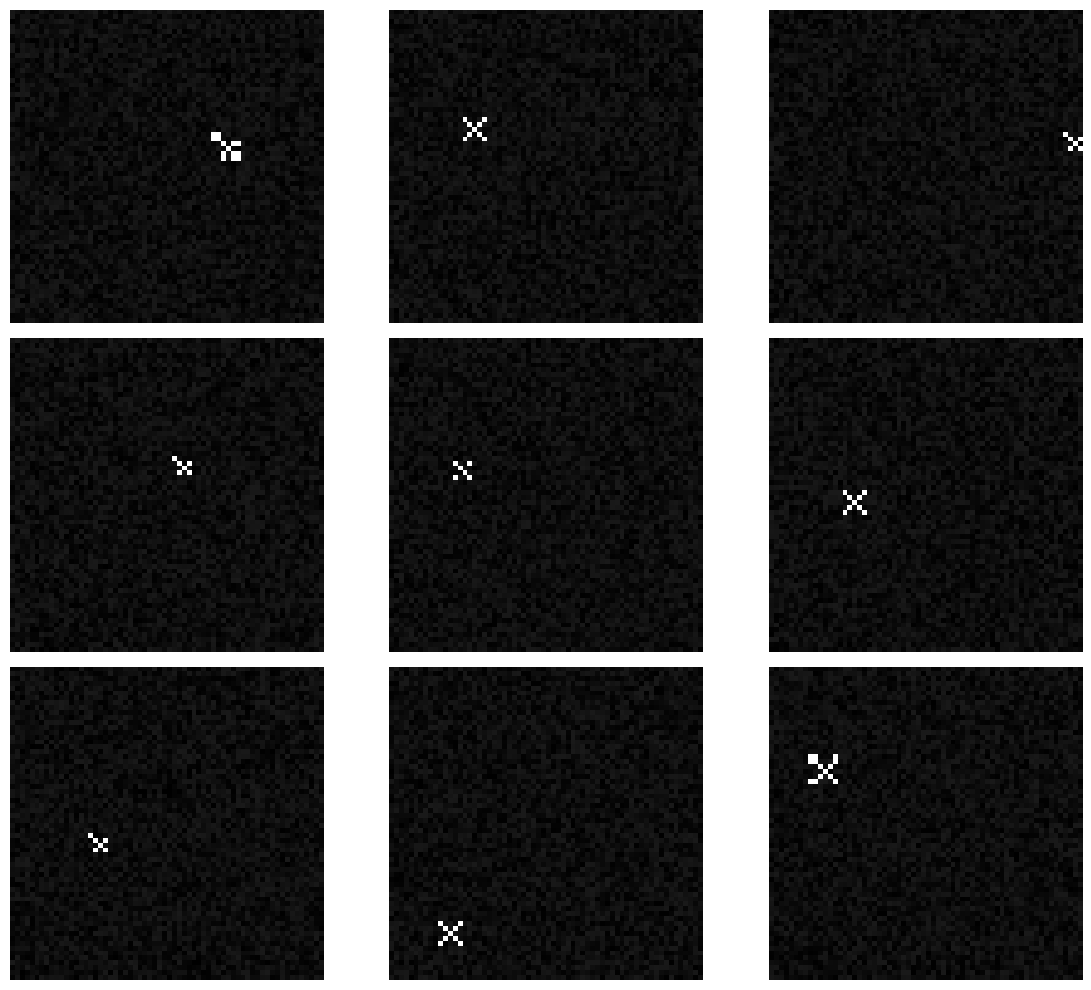

In [5]:
def show_images_grid(data_dir='training_data', num_images=9, rows=3, cols=3):
    # image_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.png')])[:num_images]
    image_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.png')])[-num_images:]
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, 10))
    for idx, ax in enumerate(axes.flat):
        if idx < len(image_files):
            img_path = os.path.join(data_dir, image_files[idx])
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            ax.imshow(img, cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')  # 不足的格子關掉
    plt.tight_layout()
    plt.show()

show_images_grid()


In [6]:
# 2. 加載和處理data

class XODataset(Dataset):
    def __init__(self, data_dir): 
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('.png')] # 讀取data_d 路徑裡的所有pngpng
        self.data_dir = data_dir

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_files[idx])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)                   # 用cv2.IMREAD_GRAYSCALE 讀取單通道圖像，RGB三通道變成 cv2.imread(img_path)[..., ::-1]（BGR→RGB）
        img = cv2.resize(img, (64, 64))                                    # 確保訓練圖片統一大小，在進模型前是 64x64，與網格對齊
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0) / 255.0  # 添加channel dim，比如黑白是: [1,H,W]
        
        label_path = img_path.replace('.png', '.txt')           #txt: <class_idx> <x_center> <y_center> <width> <height>
        with open(label_path, 'r') as f:
            line = f.readline().strip().split()                 # 讀取第一行並分割
                                                                # 這裡每個圖像只有一個Object，真正在做YOLO不會只有一個，要改成循環讀取所有rows，而不是只有第一個f.readlines()
            
            label = torch.tensor([float(x) for x in line[1:]])  # 轉為數值
            class_idx = int(line[0])                            # 類別索引

        # <class_idx> <x_center> <y_center> <width> <height> <confidence> <label 0> <label 1>
        target = torch.zeros(7)                                 # 假設輸出維度為7
        target[:4] = torch.tensor(label)                        # x,y,w,h
        target[4] = 1.0                                         # 信心度（表示有物體）
        target[5 + class_idx] = 1.0                             # one-hot
        
        return img, target


In [7]:
# 3. 定義模型(加上forward 的處理)

class TinyYOLO(nn.Module):
    def __init__(self, grid_size=8, num_classes=2): # 這裡是單通道 64x64 圖像
        super().__init__()
        self.grid_size = grid_size

        self.norm = nn.BatchNorm2d(1)  # 對單通道inputs做 Normalize
        
        # 用 3個 Conv+ReLU+MaxPool的block 逐步做undersampling
        self.cnn = nn.Sequential(
            
            nn.Conv2d(1, 16, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64 -> 32
            
            nn.Conv2d(16, 32, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32 -> 16
            
            nn.Conv2d(32, 64, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2),   # 16 -> 8
        )
        
        self.head = nn.Conv2d(64, 5 + num_classes, 1) # 最後，head 卷積層將通道數擴展到 5 + num_classes

# inputs: [Batch size, 1, 64, 64]   1: channel、64: cell
# outputs:  [Batch size , 8, 8, 7]  8: cell、7: 7個預測值([x, y, w, h, confidence, class1_prob, class2_prob])
    
    def forward(self, x):
        x = self.cnn(x)  # 由CNN 把1 channel變成64 channel，且grid 由undersampling 到 8*8，[B,1,64,64] -> [B,64,8,8]
        x = self.head(x)  # 最終預測卷積， [B,64,8,8] -> [B,7,8,8]
        x = x.permute(0, 2, 3, 1)  # 把7個預測值擺到最後， [B,7,8,8] -> [B,8,8,7]

# Note: 那個self.head(x) 就是一個 1x1的捲積核(filter)，這裡就剛好是: nn.Conv2d(64, 7, kernel_size=1)，大小是: [64,1,1]，
# 原本[B,64,8,8]有64個channe的feature map、每個feature map都是8x8，用[64,1,1]的filter，取weighting sum變成1個channel，
# 有7個捲積核，所以outputs變成[B, 7, 8, 8]

        # 分別處理
        bbox = x[..., 0:4]               # [x, y, w, h]
        conf = torch.sigmoid(x[..., 4])  # confidence 用 sigmoid 映射到 0~1
        class_logits = x[..., 5:]        # raw logits，不做 softmax

        # 合併
        out = torch.cat([bbox, conf.unsqueeze(-1), class_logits], dim=-1)
        return out

In [8]:
# 4. 訓練步驟

def train():
    set_seed(123)
    
    # 如果 training_data 資料夾不存在或圖片檔不足，重新生成
    need_regen = False
    if not os.path.exists('training_data'):
        need_regen = True
    else:
        image_files = [f for f in os.listdir('training_data') if f.endswith('.png')]
        if len(image_files) == 0:
            need_regen = True

    if need_regen:
        generate_data(100) # need_regen = False: generate_data 會生成圖片和標註文件

    # 使用 XODataset 加載數據
    dataset = XODataset('training_data')
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    model = TinyYOLO()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(20):
        total_loss = 0
        for imgs, targets in dataloader:
            preds = model(imgs)
            loss = yolo_loss(preds, prepare_targets(targets))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}')
    # torch.save(model.state_dict(), 'tiny_yolo.pth')

# 4. 損失函數
def yolo_loss(preds, targets, lambda_coord=5.0, lambda_noobj=0.1, lambda_cls=3.0):
    obj_mask = targets[..., 4] > 0.5    # 信心度 > 0.5，認為是有物體
    noobj_mask = targets[..., 4] <= 0.5

    # 座標loss（預測框與真實框的 MSE），都只計算有物體的網格
    bbox_loss = nn.MSELoss()(preds[obj_mask][..., 0:2], targets[obj_mask][..., 0:2]) \
              + nn.MSELoss()(torch.sqrt(torch.clamp(preds[obj_mask][..., 2:4], min=1e-6)),
                             torch.sqrt(torch.clamp(targets[obj_mask][..., 2:4], min=1e-6)))

    # 2. 信心度loss (區分有/無物體，Binary CrossEntropy)，focal loss 也行
    bce = nn.BCEWithLogitsLoss()
    conf_loss_obj = bce(preds[obj_mask][..., 4], targets[obj_mask][..., 4])
    conf_loss_noobj = bce(preds[noobj_mask][..., 4], targets[noobj_mask][..., 4])

    # 分類loss (用 CrossEntropy，target 為 class index)
    class_loss = nn.CrossEntropyLoss()(preds[obj_mask][..., 5:], targets[obj_mask][..., 5].long())
    # class_loss = nn.CrossEntropyLoss()(preds[obj_mask][..., 5:], targets[obj_mask][..., 5:].argmax(dim=1))

    total_loss = lambda_coord * bbox_loss + conf_loss_obj + lambda_noobj * conf_loss_noobj + lambda_cls * class_loss
    return total_loss  # total loss <- 這是假設每個網格只有一個目標，如果有多個目標，要對每個target 的loss加起來

# 6. 目標編碼(將原始標註轉換為網格格式)

def prepare_targets(targets, grid_size=8):
    batch_targets = torch.zeros(len(targets), grid_size, grid_size, 6)  # 最後一欄是 class index

    for i, target in enumerate(targets):
        cx, cy, w, h = target[:4] * grid_size      # 轉換到網格坐標系
        grid_x = min(int(cx), grid_size - 1)       # 計算所屬網格cell
        grid_y = min(int(cy), grid_size - 1)
        class_idx = int(target[5])                 # 類別索引

        batch_targets[i, grid_y, grid_x] = torch.tensor([
            cx - grid_x,     # 網格內相對偏移x (0~1)
            cy - grid_y,     # 網格內相對偏移y
            w, h,            # 寬高（保持原數值
            1.0,             # 信心度
            class_idx        # 類別機率
        ])

    # 比如說: cx=0.6, cy=0.7, grid_size=8 → grid_x=4, grid_y=5
    # 存儲：[0.6*8-4=0.8, 0.7*8-5=0.6, w, h, 1.0, class...]
    
    return batch_targets

if __name__ == "__main__":
    train()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2932\1453213986.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target[:4] = torch.tensor(label)                        # x,y,w,h


Epoch 1, Loss: 4.4696
Epoch 2, Loss: 2.9042
Epoch 3, Loss: 2.5100
Epoch 4, Loss: 1.5869
Epoch 5, Loss: 0.8330
Epoch 6, Loss: 0.6390
Epoch 7, Loss: 0.5963
Epoch 8, Loss: 0.5646
Epoch 9, Loss: 0.5505
Epoch 10, Loss: 0.5426
Epoch 11, Loss: 0.5412
Epoch 12, Loss: 0.5293
Epoch 13, Loss: 0.5257
Epoch 14, Loss: 0.5183
Epoch 15, Loss: 0.5218
Epoch 16, Loss: 0.5124
Epoch 17, Loss: 0.5167
Epoch 18, Loss: 0.5084
Epoch 19, Loss: 0.5076
Epoch 20, Loss: 0.5070


In [9]:
# 生成50筆test data
generate_data(num_samples=20, output_dir='test_data')

Generated 20 images in 'test_data/'


In [10]:
# 7. 沒有NMS 的預測
def predict(model, img_path, conf_threshold=0.5, show=False, save=True, debug=False):
    model.eval()
    
    # 1. 圖像讀取與前處理
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to read {img_path}")
        return
    
    img = cv2.resize(img, (64, 64))
    original = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)
    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0
    
    # 2. 模型推理
    with torch.no_grad():
        pred = model(img_tensor)[0]  # [8,8,7]
        print(f"pred.shape = {pred.shape}")

    # 3. 解碼與視覺化（格式統一為 predict_with_nms 樣式）
    boxes = []
    scores = []
    class_ids = []

    for i in range(8):
        for j in range(8):
            conf = pred[i, j, 4].item()
            if debug:
                print(f"[Grid {i},{j}] conf={conf:.3f}, class_logits={pred[i,j,5:].numpy()}")

            if conf > conf_threshold:
                cx = (j + pred[i, j, 0].item()) / 8 * 64
                cy = (i + pred[i, j, 1].item()) / 8 * 64
                w = pred[i, j, 2].item() * 64
                h = pred[i, j, 3].item() * 64

                x1 = max(0, cx - w / 2)
                y1 = max(0, cy - h / 2)
                x2 = min(63, cx + w / 2)
                y2 = min(63, cy + h / 2)

                class_logits = pred[i, j, 5:]
                # class_probs = F.softmax(class_logits, dim=0)
                class_probs = nn.Softmax(dim=0)(class_logits)
                cls = torch.argmax(class_probs).item()

                boxes.append([x1, y1, x2, y2])
                scores.append(conf)
                class_ids.append(cls)

                label = 'O' if cls == 0 else 'X'
                color = (0, 255, 0) if cls == 0 else (0, 0, 255)

                # print(f"Detected {label}: conf={conf:.2f}, box=({x1:.1f},{y1:.1f},{x2:.1f},{y2:.1f})")

                cv2.rectangle(original, (int(x1), int(y1)), (int(x2), int(y2)), color, 1)
                cv2.putText(original, f"{label} {conf:.2f}", (int(x1), int(y1) - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # 4. 儲存與顯示
    if boxes:
        if save:
            os.makedirs('predict_data', exist_ok=True)
            save_path = os.path.join('predict_data', os.path.basename(img_path))
            cv2.imwrite(save_path, original)
            print(f"Saved detection result to: {save_path}")

        if show:
            cv2.imshow("Prediction", original)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
    else:
        print(f"No object detected in {img_path}")
    return boxes, scores, class_ids


In [11]:
# 8. NMS

def manual_nms(boxes, scores, iou_threshold=0.5):
    # boxes: Tensor[N,4] (x1,y1,x2,y2 格式)
    # scores: Tensor[N]
    # iou_threshold: 重疊閾值
    
    # 按scores 遞減排序
    sorted_indices = torch.argsort(scores, descending=True)
    keep = []
    
    while sorted_indices.numel() > 0:
        # 當前最高分框
        best_idx = sorted_indices[0]
        keep.append(best_idx.item())
        
        if sorted_indices.numel() == 1:
            break
            
        # 計算與其他框的 IoU
        best_box = boxes[best_idx]             # boxes: Tensor[N,4] (x1,y1,x2,y2 格式)
        other_boxes = boxes[sorted_indices[1:]]
        
        # 計算交集區域
        x1 = torch.max(best_box[0], other_boxes[:, 0])
        y1 = torch.max(best_box[1], other_boxes[:, 1])
        x2 = torch.min(best_box[2], other_boxes[:, 2])
        y2 = torch.min(best_box[3], other_boxes[:, 3])
        
        # 計算交集面積
        inter = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)
        
        # 計算並集面積
        area_best = (best_box[2] - best_box[0]) * (best_box[3] - best_box[1])
        area_other = (other_boxes[:, 2] - other_boxes[:, 0]) * (other_boxes[:, 3] - other_boxes[:, 1])
        union = area_best + area_other - inter
        
        # 計算 IoU
        iou = inter / (union + 1e-6)
        
        # 保留 IoU 低於閾值的框
        mask = iou <= iou_threshold
        sorted_indices = sorted_indices[1:][mask]
    
    return keep  # keep: 保留的索引列表

In [12]:
# 9. 網格感知 NMS(未完成)
def grid_aware_nms(boxes, scores, grid_positions, iou_thresh=0.01, grid_thresh=1):
    """
    Args:
        grid_positions: 每個框對應的網格坐標 [N,2] (grid_y, grid_x)
        grid_thresh: 相鄰網格閾值 (默認1=直接相鄰網格)
    """
    keep = []
    order = torch.argsort(scores, descending=True)
    
    while order.size(0) > 0:
        best_idx = order[0]
        keep.append(best_idx.item())
        
        if order.size(0) == 1:
            break
            
        # 計算幾何IoU
        iou = box_iou(boxes[best_idx:best_idx+1], boxes[order[1:]])[0]
        
        # 計算網格距離
        grid_dist = torch.norm(grid_positions[order[1:]] - grid_positions[best_idx], dim=1)
        
        # 組合抑制條件
        suppress = (iou > iou_thresh) | (grid_dist <= grid_thresh)
        order = order[1:][~suppress]
    
    return keep

In [13]:
# 10. 有NMS 的預測

def predict_with_nms(model, img_path, conf_threshold=0.5, iou_threshold=0.5, show=False, save=True, debug=False):
    model.eval()
    
    # 1. 圖像讀取與預處理
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to read {img_path}")
        return [], [], []
        
    img = cv2.resize(img, (64, 64))
    original = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)
    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0
    
    # 2. 模型推理
    with torch.no_grad():
        pred = model(img_tensor)[0]  # shape: [8,8,7]
        if debug:
            print(f"Raw prediction shape: {pred.shape}")

    # 3. 解碼所有預測框
    boxes = []
    scores = []
    class_ids = []
    
    for i in range(8):  # grid_y
        for j in range(8):  # grid_x
            conf = torch.sigmoid(pred[i, j, 4]).item()  # 使用sigmoid確保置信度在[0,1]
            
            if conf > conf_threshold:
                class_logits = pred[i, j, 5:].tolist()
                
                # 計算絕對坐標 (中心點格式 -> 角點格式)
                cx = (j + torch.sigmoid(pred[i, j, 0]).item()) / 8 * 64
                cy = (i + torch.sigmoid(pred[i, j, 1]).item()) / 8 * 64
                w = torch.sigmoid(pred[i, j, 2]).item() * 64 * 1.2  # 寬度補償係數
                h = torch.sigmoid(pred[i, j, 3]).item() * 64 * 1.2
                
                x1 = max(0, cx - w/2)
                y1 = max(0, cy - h/2)
                x2 = min(63, cx + w/2)  # 限制在圖像範圍內
                y2 = min(63, cy + h/2)
                
                boxes.append([x1, y1, x2, y2])
                scores.append(conf)
                class_ids.append(torch.argmax(pred[i, j, 5:]).item())
                
                if debug:
                    cls = class_ids[-1]
                    print(f"Grid[{i},{j}] conf={conf:.2f}, class={cls}, box=({x1:.1f},{y1:.1f},{x2:.1f},{y2:.1f}), class logits: O={class_logits[0]:.2f}, X={class_logits[1]:.2f}")

    # 4. 應用手動NMS
    if len(boxes) > 0:
        boxes_tensor = torch.tensor(boxes)  # [N,4]
        scores_tensor = torch.tensor(scores)  # [N]
        
        # 手動實現的NMS (可替換為自己的 manual_nms 函數)
        keep = manual_nms(boxes_tensor, scores_tensor, iou_threshold)
        
        final_boxes = [boxes[i] for i in keep]
        final_scores = [scores[i] for i in keep]
        final_classes = [class_ids[i] for i in keep]
    else:
        final_boxes, final_scores, final_classes = [], [], []
        print(f"No objects detected (conf < {conf_threshold}) in {img_path}")

    # 5. 可視化結果
    for box, score, cls in zip(final_boxes, final_scores, final_classes):
        x1, y1, x2, y2 = map(int, box)
        label = 'O' if cls == 0 else 'X'
        color = (0, 255, 0) if cls == 0 else (0, 0, 255)
        
        cv2.rectangle(original, (x1, y1), (x2, y2), color, 1)
        cv2.putText(original, f"{label} {score:.2f}", 
                   (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # 6. 保存/顯示結果
    if save and final_boxes:
        os.makedirs('predict_data', exist_ok=True)
        save_path = os.path.join('predict_data', os.path.basename(img_path))
        cv2.imwrite(save_path, original)
        print(f"Saved detection result to: {save_path}")

    if show and final_boxes:
        cv2.imshow("Prediction", original)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    return final_boxes, final_scores, final_classes

In [14]:
# 11. 初始化模型

model = TinyYOLO()
# model.load_state_dict(torch.load('tiny_yolo.pth'))  # 如果有存模型的話
model.eval()

TinyYOLO(
  (norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (head): Conv2d(64, 7, kernel_size=(1, 1), stride=(1, 1))
)

In [19]:
# 12. 預測 nms

boxes, scores, classes = predict_with_nms(
    model, 
    "test_data/1_10.png",
    conf_threshold=0.6,  # 可調參數，調高減少誤檢，調低增加檢出
    iou_threshold=0.01,   # 可調參數，調高允許更多重疊，調低減少重複框
    show=False,
    debug=False
)

# 輸出結果
print(f"Detected {len(boxes)} objects:")
for i, (box, score, cls) in enumerate(zip(boxes, scores, classes)):
    print(f"Object {i+1}: class={'O' if cls==0 else 'X'}, score={score:.2f}, box={box}")

Saved detection result to: predict_data\1_10.png
Detected 3 objects:
Object 1: class=O, score=0.63, box=[0, 0, 22.04238681793213, 30.74827618598938]
Object 2: class=O, score=0.62, box=[42.15093860626221, 16.517833518981934, 63, 55.04822750091553]
Object 3: class=O, score=0.62, box=[2.184641551971435, 32.5459125995636, 38.17823057174682, 63]


In [20]:
# 13. 預測 nms

boxes, scores, classes = predict_with_nms(
    model, 
    "test_data/0_4.png",
    conf_threshold=0.6,  # 可調參數，調高減少誤檢，調低增加檢出
    iou_threshold=0.01,   # 可調參數，調高允許更多重疊，調低減少重複框
    show=False,
    debug=False
)

# 輸出結果
print(f"Detected {len(boxes)} objects:")
for i, (box, score, cls) in enumerate(zip(boxes, scores, classes)):
    print(f"Object {i+1}: class={'O' if cls==0 else 'X'}, score={score:.2f}, box={box}")

Saved detection result to: predict_data\0_4.png
Detected 4 objects:
Object 1: class=O, score=0.63, box=[26.338051414489748, 24.510526847839355, 62.05142726898193, 63]
Object 2: class=O, score=0.62, box=[0, 0, 22.20884962081909, 31.056566524505616]
Object 3: class=O, score=0.62, box=[0, 32.518705224990846, 22.19421453475952, 63]
Object 4: class=O, score=0.62, box=[42.107575225830075, 0, 63, 22.967547941207886]
